In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import librosa
import librosa.display
from xgboost import XGBRegressor

ModuleNotFoundError: No module named 'librosa'

In [2]:
#Read the file

df = pd.read_csv("DSL_Winter_Project_2025/development.csv", index_col=0)  

In [3]:
# Function to extract mean, std from log-mel spectrogram, words per second, formant frequencies, MFCCs, and voiced/unvoiced ratio

def extract_audio_features(file_path, num_words):
    
    data, sig = librosa.load(f"DSL_Winter_Project_2025/{file_path}")
    
    spectrogram = librosa.feature.melspectrogram(y=data, sr=sig, n_mels=40)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    mean = np.mean(log_spectrogram, axis=1)
    std = np.std(log_spectrogram, axis=1)

    duration = len(data) / sig 
    words_per_second = num_words / duration
    
    mfcc = librosa.feature.mfcc(y=data, sr=sig, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    
    voiced_frames = librosa.effects.split(data, top_db=20) 
    voiced_duration = sum([end - start for start, end in voiced_frames]) / sig  
    unvoiced_duration = duration - voiced_duration
    voiced_unvoiced_ratio = voiced_duration / unvoiced_duration if unvoiced_duration > 0 else 1.0
    
    return np.concatenate([mean, std, 
                           [words_per_second], 
                           mfcc_mean, mfcc_std, 
                           [voiced_unvoiced_ratio]])

features = df.apply(lambda row: pd.Series(extract_audio_features(row['path'], row['num_words']),
                                          index=[f'mean_{i}' for i in range(40)] +
                                                [f'std_{i}' for i in range(40)] + 
                                                ['words_per_second'] +
                                                [f'mfcc_mean_{i}' for i in range(13)] + 
                                                [f'mfcc_std_{i}' for i in range(13)] +
                                                ['voiced_unvoiced_ratio']), axis=1)

df = pd.concat([df, features], axis=1)

In [4]:
# Drop the path column that is now useless, and encode gender, plus remove brackets 

df_d1 = df.drop(columns=['path'])
df_d1 = pd.get_dummies(df_d1, columns=['gender'])
ethnicity_column = df['ethnicity']
df_d1 = df_d1.drop(columns=['ethnicity'])
df_d1 = df_d1.replace(r'[\[\]]', '', regex=True)  # Remove brackets
df_d1 = df_d1.apply(pd.to_numeric, errors='coerce')  # Convert to numeric
df_1h = df_d1.astype(float)
df_1h['ethnicity'] = ethnicity_column
df_dropeth = df_1h.drop(columns=['ethnicity'])

In [5]:
#Read the evaluation dataset and apply the audio features function

df_ev = pd.read_csv("DSL_Winter_Project_2025/evaluation.csv", index_col=0) 

features_ev = df_ev.apply(lambda row: pd.Series(extract_audio_features(row['path'], row['num_words']),
                                          index=[f'mean_{i}' for i in range(40)] +
                                                [f'std_{i}' for i in range(40)] + 
                                                ['words_per_second'] +
                                                [f'mfcc_mean_{i}' for i in range(13)] + 
                                                [f'mfcc_std_{i}' for i in range(13)] +
                                                ['voiced_unvoiced_ratio']), axis=1)

df_ev = pd.concat([df_ev, features_ev], axis=1)
df_ev = df_ev.drop(columns=['path'])

In [6]:
#As before apply the 1h encoding of gender and remove the brackets

df_ev_1h = pd.get_dummies(df_ev, columns=['gender'])
ethnicity_column = df_ev_1h['ethnicity']
df_ev_1h = df_ev_1h.drop(columns=['ethnicity'])
df_ev_1h = df_ev_1h.replace(r'[\[\]]', '', regex=True)  # Remove brackets
df_ev_1h = df_ev_1h.apply(pd.to_numeric, errors='coerce')  # Convert to numeric
df_ev_1h = df_ev_1h.astype(float)
df_ev_1h['ethnicity'] = ethnicity_column

In [7]:
# Remove typo

df_ev_1h['gender_female'] = (df_ev_1h['gender_famale'] == 1).astype(int)
df_ev_1h.drop('gender_famale', axis=1, inplace=True)
df_ev_dropeth = df_ev_1h.drop(columns=['ethnicity'])

In [8]:
#Try to have a first idea of the age column so we can add a new feature

X_train = df_dropeth.drop(columns=["age"]).values
y_train = df_dropeth["age"].values
X_test = df_ev_dropeth.values

rfr_noeth = RandomForestRegressor(criterion= 'poisson', max_depth= 20, max_features= None, n_estimators= 250, random_state= 42)
rfr_noeth.fit(X_train, y_train)
pred_rfr_noeth=rfr_noeth.predict(X_test)
df_ev_1h['age'] = pred_rfr_noeth

In [9]:
#Concatenate the train and test dataset

df_com_1h = pd.concat([df_1h, df_ev_1h], sort=False)
df_com_1h = df_com_1h.reset_index(drop=True)

In [10]:
# Function to calculate sliding window statistics for the next feature

def calculate_sliding_window_stats(df, age_column, feature_columns, window_size=10):
    means = []
    stds = []
    for _, row in df.iterrows():
        lower_bound = row[age_column] - window_size
        upper_bound = row[age_column] + window_size
        window_data = df[(df[age_column] >= lower_bound) & (df[age_column] <= upper_bound)]

        means.append(window_data[feature_columns].mean())
        stds.append(window_data[feature_columns].std())
    
    return pd.DataFrame(means), pd.DataFrame(stds)

In [11]:
#Compute mean and std of every non-cathegorical column by the sliding window age

feature_columns = [
    col for col in df_com_1h.columns 
    if col not in ['age', 'ethnicity', 'gender_male', 'gender_female'] 
]

means, stds = calculate_sliding_window_stats(df_com_1h, 'age', feature_columns)

means.columns = [f'{col}__mean' for col in feature_columns]
stds.columns = [f'{col}__std' for col in feature_columns]
df_com_1h = pd.concat([df_com_1h, means, stds], axis=1)

In [12]:
#Compute deviations for every feature and add them to the dataset

deviations = {
    f'{col}__deviation': (df_com_1h[col] - df_com_1h[f'{col}__mean']) / df_com_1h[f'{col}__std'] 
    for col in feature_columns
}

deviations_df = pd.DataFrame(deviations)
df_com_1h = pd.concat([df_com_1h, deviations_df], axis=1)

In [13]:
#Compute the ethnicity behaviour by computing the average deviation aggregated by ethnicity

ethnicity_behavior = df_com_1h.groupby('ethnicity').agg(
    **{f'{col}_behavior': (f'{col}__deviation', 'mean') for col in feature_columns}
).reset_index()

ethnicity_behavior['ethnicity_behavior'] = ethnicity_behavior[
    [f'{col}_behavior' for col in feature_columns]
].mean(axis=1)

df_com_1h = df_com_1h.merge(
    ethnicity_behavior[['ethnicity', 'ethnicity_behavior']], on='ethnicity', how='left'
)

In [14]:
#Drop the now useless features and print the list of unique ethnicities

columns_to_drop = [col for col in df_com_1h.columns if '__mean' in col or '__std' in col or '__deviation' in col]
df_com_1h = df_com_1h.drop(columns=columns_to_drop)

un_eth=df_com_1h['ethnicity'].unique()
print(un_eth)

['arabic' 'hungarian' 'portuguese' 'english' 'dutch' 'italian' 'french'
 'igbo' 'hebrew' 'farsi' 'german' 'nama' 'belarusan' 'urhobo' 'polish'
 'croatian' 'kikuyu' 'icelandic' 'bengali' 'maltese' 'finnish' 'armenian'
 'hindi' 'bosnian' 'miskito' 'azerbaijani' 'kiswahili' 'mongolian'
 'russian' 'malay' 'bulgarian' 'gan' 'cantonese' 'punjabi' 'nigerian'
 'mandarin' 'oriya' 'igala' 'japanese' 'ga' 'ibibio' 'korean' 'amharic'
 'gujarati' 'norwegian' 'kurdish' 'congolese' 'marathi' 'ijaw' 'nepali'
 'indonesian' 'yoruba' 'bari' 'kanuri' 'pashto' 'romanian' 'albanian'
 'georgian' 'baga' 'macedonian' 'danish' 'khmer' 'catalan' 'papiamentu'
 'naxi' 'czech' 'mizo' 'irish' 'agni' 'hausa' 'estonian' 'ika' 'bafang'
 'quechua' 'lithuanian' 'afemai' 'ikwerre' 'luxembourgeois' 'moore'
 'kabyle' 'fijian' 'greek' 'mankanya' "sa'a" 'bai' 'bambara' 'lao'
 'konkani' 'ilonggo' 'ewe' 'newari' 'krio' 'oromo' 'garifuna' 'hadiyya'
 'satawalese' 'amazigh' 'latvian' 'mandinka' 'obudu' 'ife' 'akan'
 'kambaata' 'da

In [15]:
#Cluster of the different ethnicities in similar groups and subgroups

groups = {
    "European": {
        "Romance": [
            "portuguese", "italian", "french", "romanian", "catalan", "maltese", "albanian", "greek", "sardinian", "spanish", "sicilian", "basque"
        ],
        "Germanic": [
            "english", "dutch", "german", "icelandic", "norwegian", "swedish", "danish", "luxembourgeois", 
            "frisian", "vlaams", "bavarian", "yiddish", "faroese", "irish"
        ],
        "Slavic": [
            "polish", "belarusan", "croatian", "bosnian", "russian", "ukrainian", "serbian", "czech", "slovak", 
            "slovenian", "macedonian", "bulgarian"
        ],
        "Baltic": [
            "lithuanian", "latvian", "finnish", "estonian", "hungarian"
        ]
    },

    "African": {
        "Chadic": [
            "hausa", "fulani", "kanuri", "pulaar", "susu", "nama", "nigerian"
        ],
        "Niger-Congo": [
            "igbo", "xhosa", "shona", "bambara", "akan", "ewe", "ganda", "twi", 
            "kikuyu", "kambaata", "wolof", "mandingo", "kikongo", "lingala", "rundi", "rwanda", "bari", "congolese", "mende", "krio", "garifuna", "hadiyya", "agni", "bafang",
            "ikwerre", "moore", "kabyle", "mankanya", "kamberka", "baga", "igala", "fanti", "urhobo", "sotho", "tiv", "luo",
            "ijaw", "mizo", "ika", "afemai", "amazigh", "mandinka", "obudu", "ife", "sarua", "ukwani", "lamotrekese", "kru", "gusii",
            "ngemba", "fataluku", "rotuman", "edo", "annang", "hindko", "moba", "jola", "ebira", "gedeo", "chittagonian", "nandi",
            "bamun", "kalanga", "nuer", "cameroonian", "dinka", "mortlockese", "fang", "ikom", "xasonga", "ekoi", "shan", "okobo", "okirika",
            "sesotho", "shilluk", "serer", "lokaa", "tswana", "ogoni"
        ],
        "Omotic": [
            "oromo", "somali", "hadiyya", "sudanese", "amharic"
        ],
        "Bantu": [
            "zulu", "xhosa", "swahili", "kiswahili", "igbo", "yoruba", "bantu", "chichewa", "ganda", "mandingo", "ashanti", "mangbettu", "mbundu",
            "mauritian", "gedeo", "jola", "nandi", "bamun", "kalanga", "nuer", "cameroonian", "dinka", "mortlockese", "fang", "sotho", "shilluk", "serer"
        ]
    },

    "Asian": {
        "Chinese Languages": [
            "mandarin", "cantonese", "teochew", "hakka", "taiwanese", "gan", "bai", "hainanese", 
            "wu", "xiang", "naxi", "chinese", "taishan", "hmong"
        ],
        "Tibetic": [
            "tibetan", "bhutani", "mongolian", "burmese"
        ],
        "Other Asian": [
            "japanese", "korean", "ga", "ibibio", "nepali", "punjabi", "oriya", "tamil", "telugu", 
            "tatar", "synthesized", "tajiki", "temne", "turkmen", "turkish", "kurdish", "pashto", "khmer",
            "vietnamese", "sinhalese", "tajik", "thai", "yakut", "sinhala", "yupik", "lao"
        ],
        "Indo-Asian": [
            "farsi", "hindi", "punjabi", "gujarati", "marathi", "pashto", "sindhi", "nepali", 
            "bengali", "oriya", "kurdish", "kannada", "dari", "indian"
        ]
    },

    "Middle-Eastern": {
        "Indo-Iranian": [
            "farsi", "hindi", "punjabi", "gujarati", "marathi", "pashto", "sindhi", "nepali", 
            "bengali", "oriya", "kurdish", "kannada", "dari", "indian"
        ],
        "Turkic": [
            "turkish", "kazakh", "uzbek", "kyrgyz", "turkmen", "uyghur", "azerbaijani", "armenian", "georgian", "kirghiz"
        ],
        "Semitic": [
            "arabic", "hebrew", "amharic", "tigrigna", "chaldean", "assamese", "urdu"
        ]
    },

    "Oceanian": {
        "Austronesian": [
            "malay", "indonesian", "filipino", "cebuano", "malagasy",
            "chamorro", "sundanese", "kaire-kaire", "sylheti", "miskito", "sundansese",
            "malayalam", "papiamentu", "lamaholot", "ilonggo", "tagalog", "yapese", "carolinian"
        ],
        "Indigenous": [
            "quechua", "satawalese", "sa'a", "bafang", "konkani", "pohnpeian", "samoan", "fijian", "hawaiian", "newari", "aboriginal"
        ]
    }
}

In [16]:
#Check if there are any missing ethnicities

all_languages = []

def flatten_dict(d):
    for key, value in d.items():
        if isinstance(value, dict):
            flatten_dict(value)
        elif isinstance(value, list):
            all_languages.extend(value)

flatten_dict(groups)

missing_languages = [lang for lang in un_eth if lang not in all_languages]

if missing_languages:
    print(f"These languages are missing from the dictionary: {missing_languages}")
else:
    print("All languages in 'un_eth' are present in the dictionary.")

All languages in 'un_eth' are present in the dictionary.


In [17]:
#Create new columns assigning 1 if an ethinicity belong to a group or subgroup

for region, ethnicities in groups.items():
    for subregion, sub_ethnicities in ethnicities.items():
        df_com_1h[subregion] = df_com_1h['ethnicity'].apply(lambda x: 1 if x in sub_ethnicities else 0)
    
    df_com_1h[region] = df_com_1h['ethnicity'].apply(lambda x: 1 if any(x in sub_ethnicities for sub_ethnicities in ethnicities.values()) else 0)

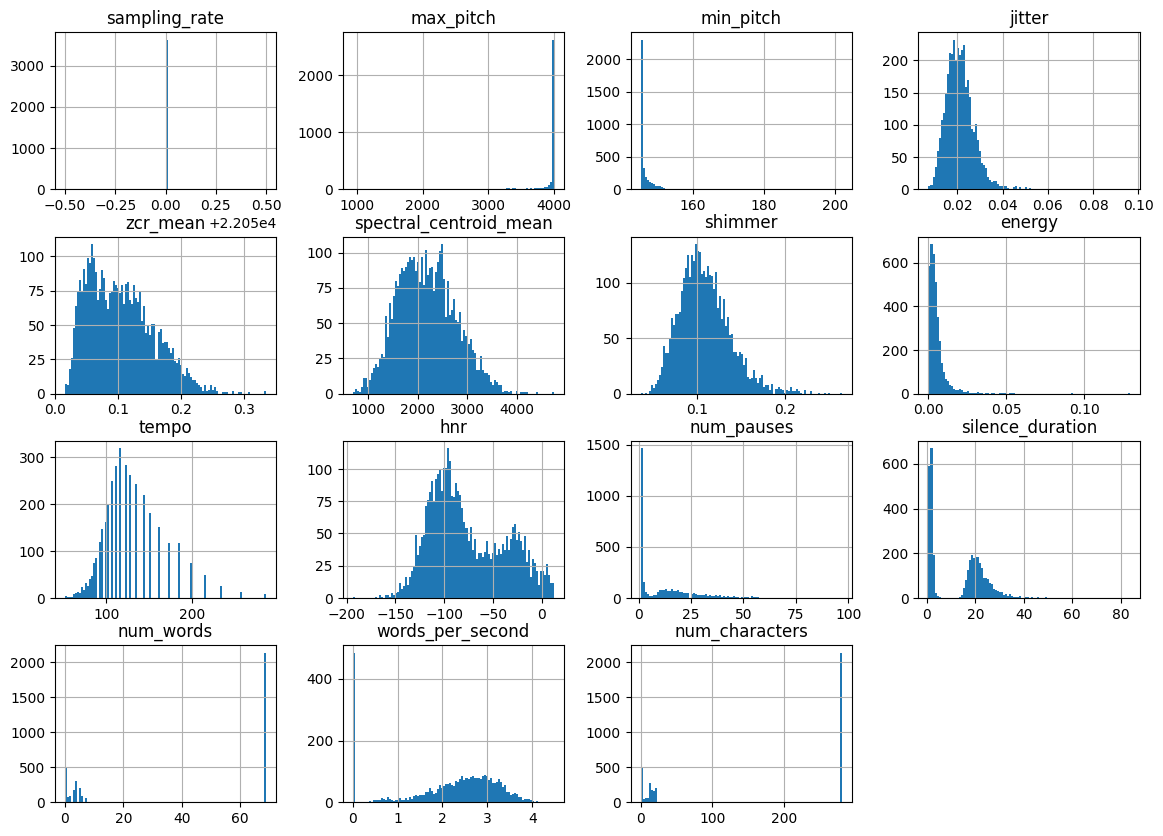

In [18]:
# Take a look at the distribution of the main features

df_emb_1h=pd.get_dummies(df_com_1h, columns=['ethnicity'])
df_emb_1h[["sampling_rate", "max_pitch", "min_pitch", "jitter","zcr_mean", "spectral_centroid_mean", "shimmer", "energy", "tempo", "hnr", "num_pauses", "silence_duration", "num_words", "words_per_second", "num_characters",]].hist(bins=100, figsize=(14, 10))
plt.show();

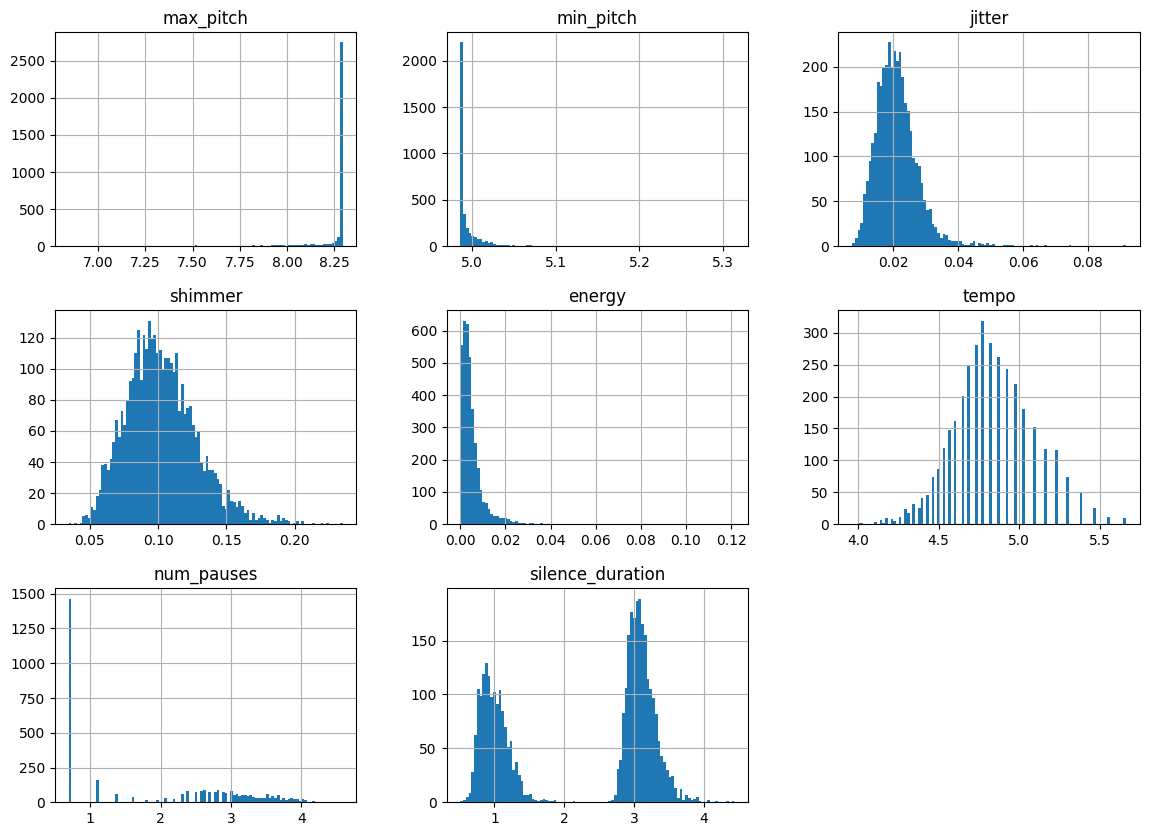

In [19]:
# Let's look at the distributions now

df_emb_1h = df_emb_1h.apply(
    lambda x: np.log1p(x)
    if x.name in ["max_pitch", "min_pitch", "jitter", "shimmer", "energy", "tempo", "num_pauses", "silence_duration"]
    else x)

df_emb_1h[["max_pitch", "min_pitch", "jitter", "shimmer", "energy", "tempo", "num_pauses", "silence_duration"]].hist(bins=100, figsize=(14, 10))
plt.show();

In [20]:
#Split again the tow dfs to prepare for the model

df_1h = df_emb_1h.iloc[:len(df_1h)]
df_ev_1h = df_emb_1h.iloc[len(df_1h):]
df_ev_1h=df_ev_1h.drop(columns='age')
df_ev_1h = df_ev_1h.reset_index(drop=True)

In [21]:
#Get the training and test sets

X_final = df_1h.drop(columns=["age"]).values
y_final = df_1h["age"].values
X_finaltest = df_ev_1h.values

In [22]:
#RandomForestRegressor with optimal parameters

rfr = RandomForestRegressor(criterion= 'poisson', max_depth= None, max_features= None, n_estimators= 500, random_state= 42)
rfr.fit(X_final, y_final)
pred_rfr=rfr.predict(X_finaltest)
print(pred_rfr[:10])

[34.152 31.168 24.3   29.728 36.122 26.14  29.849 20.338 42.708 21.662]


In [23]:
#GradientBoosting with optimal parameters

xgb = XGBRegressor(objective='reg:squarederror', random_state=42, learning_rate= 0.1, max_depth= 3, n_estimators= 250, gamma=15, reg_alpha=0.2, reg_lambda=5)
xgb.fit(X_final, y_final)
pred_xgb=xgb.predict(X_finaltest)
print(pred_xgb[:10])

[31.27767  28.276587 20.62402  27.91198  31.950872 21.808931 32.311615
 24.045582 48.59958  22.762447]


In [24]:
#Compute a hybrid solution that can be more robust and round the results

weights = [0.05, 0.95]

pred_wei = (
    weights[0] * pred_rfr +
    weights[1] * pred_xgb
)

pred_wei = np.round(pred_wei).astype(int)

In [25]:
#Export the final predictions

df_final = pd.DataFrame()
df_final['Predicted'] = pred_wei
df_final['Id'] = df_ev_1h.index
print(df_final['Predicted'][0:20])
df_final[['Id','Predicted']].to_csv("submission_FINAL_test.csv", index=False)

0     31
1     28
2     21
3     28
4     32
5     22
6     32
7     24
8     48
9     23
10    44
11    18
12    31
13    19
14    39
15    27
16    40
17    31
18    18
19    29
Name: Predicted, dtype: int32
